In [1]:
# Imports de utilidades de Python
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import git
import os, sys

path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
os.chdir(path_git)


from functions import *

2024-11-08 16:22:43.251526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
d = pd.read_csv(os.path.join(path_git, 'source', 'covidProcesado.csv'))
d.loc[:,'fecha_diagnostico'] = pd.to_datetime(d.fecha_diagnostico)
d = d.groupby(pd.Grouper(key = 'fecha_diagnostico', freq = '7D')).agg({'Confirmado' : sum,
                                                                      'tasa' : np.mean}).reset_index()
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   fecha_diagnostico  122 non-null    datetime64[ns]
 1   Confirmado         122 non-null    float64       
 2   tasa               122 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.0 KB


/home/tcicchini/anaconda3/envs/ml_env/lib/python3.9/site-packages/pandas/core/groupby/grouper.py:381: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  ax = Index(obj[key], name=key)
/tmp/ipykernel_134108/2517574532.py:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  d = d.groupby(pd.Grouper(key = 'fecha_diagnostico', freq = '7D')).agg({'Confirmado' : sum,
/tmp/ipykernel_134108/2517574532.py:3: FutureWarning: The provided callable <function mean at 0x7efdc843d040> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instea

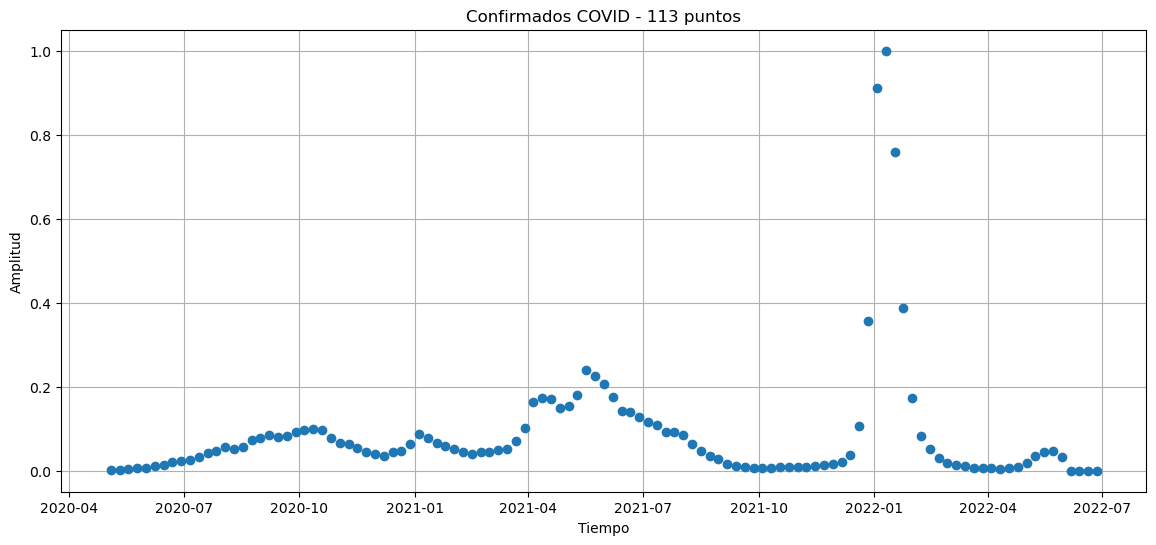

In [3]:
# Acortar la secuencia para que no sea tan larga y tenga una amplitud similar
fi = pd.to_datetime('2020-05-01') # fecha inicial
ff = pd.to_datetime('2022-07-01') # fecha final

raw_seq = d[d.fecha_diagnostico.between(fi, ff)].Confirmado.to_numpy()
raw_seq = raw_seq / raw_seq.max()
t = d[d.fecha_diagnostico.between(fi, ff)].fecha_diagnostico.to_numpy()

# Graficar la señal temporal
plt.figure(figsize=(14, 6))
plt.plot(t, raw_seq, 'o')
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title(f'Confirmados COVID - {len(t)} puntos')
plt.grid(True)
plt.show()

In [4]:
# Parámetros de la simulación

# choose a number of time steps
look_back = 5

# Cantidad de valores por cada paso temporal
n_features = 1

# Cantidad de pasos que queremos predecir hacia adelante
window_size = 20

# longitud de la cadena izquierda
len_left_chain = 50

# longitud de la cadena derecha
len_right_chain = 50

In [5]:
raw_seq_1 = raw_seq[0:len_left_chain]
t_1 = t[0:len_left_chain]

print(len(raw_seq_1),len_left_chain)

50 50


In [6]:
raw_seq_2 = raw_seq[len_left_chain+window_size:len_left_chain+window_size + len_right_chain]
t_2 = t[len_left_chain+window_size:len_left_chain+window_size + len_right_chain]

raw_seq_2_bw = raw_seq_2[::-1]
t_2_bw = t_2[::-1]

print(len(raw_seq_2),len_right_chain)

43 50


In [7]:
t_window = t[len_left_chain:len_left_chain+window_size]
raw_seq_window = raw_seq[len_left_chain:len_left_chain+window_size]
print(len(raw_seq_window),window_size)

20 20


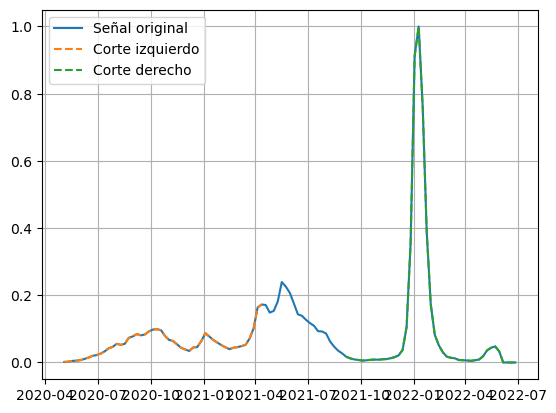

In [8]:
plt.plot(t,raw_seq, label='Señal original')
plt.plot(t_1,raw_seq_1, '--', label='Corte izquierdo')
plt.plot(t_2,raw_seq_2, '--', label='Corte derecho')
plt.grid()
plt.legend()
plt.show()

In [9]:
print('t_1 limits:',t_1[0],t_1[-1])
print('t_window limits:', t_window[0],t_window[-1])
print('t_2 limits:',t_2[0],t_2[-1])
print('t limits:',t[0],t[-1])
print('len of times:', len(t_1),len(t_window),len(t_2),len(t))

t_1 limits: 2020-05-04T00:00:00.000000000 2021-04-12T00:00:00.000000000
t_window limits: 2021-04-19T00:00:00.000000000 2021-08-30T00:00:00.000000000
t_2 limits: 2021-09-06T00:00:00.000000000 2022-06-27T00:00:00.000000000
t limits: 2020-05-04T00:00:00.000000000 2022-06-27T00:00:00.000000000
len of times: 50 20 43 113


In [10]:
predicciones_adelante_1,valores_reales_1 = make_predictions(raw_seq_1, look_back, n_features, raw_seq_window)

2024-11-08 16:22:45.291696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 0s 17ms/step


In [11]:
# Calculamos el error
diferencia_1 = np.abs(predicciones_adelante_1-raw_seq_window)

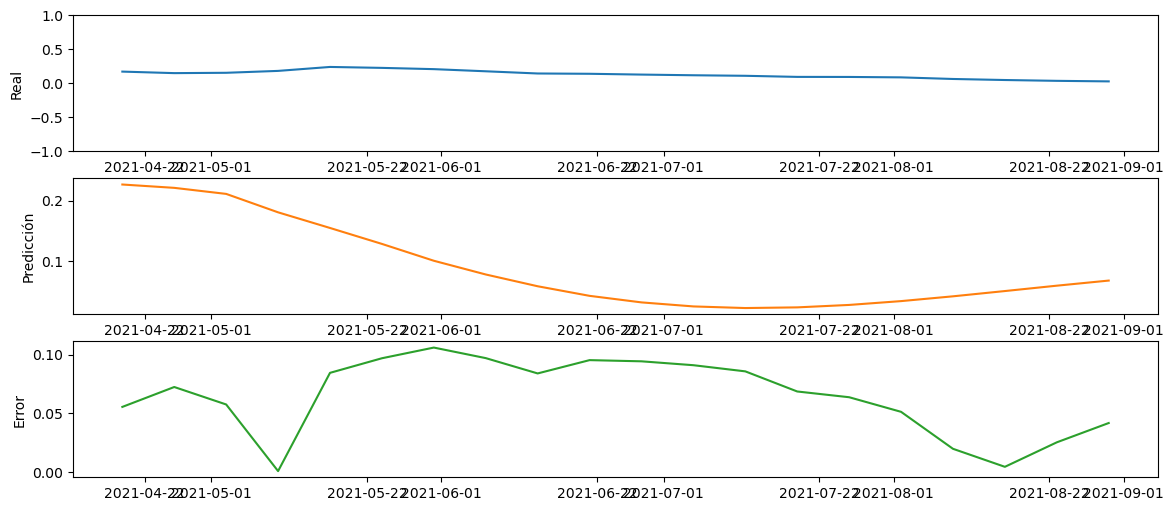

In [12]:
fig = plt.figure(figsize = (14,6))
plt.subplot(3,1,1)
plt.plot(t_window,raw_seq_window)
plt.ylabel('Real')
plt.ylim(-1,1)
plt.subplot(3,1,2)
plt.plot(t_window,predicciones_adelante_1,c='C1')
plt.ylabel('Predicción')
#plt.ylim(-1,1)
plt.subplot(3,1,3)
plt.plot(t_window,diferencia_1,c='C2')
plt.ylabel('Error')
#plt.ylim(0,5)
plt.show()

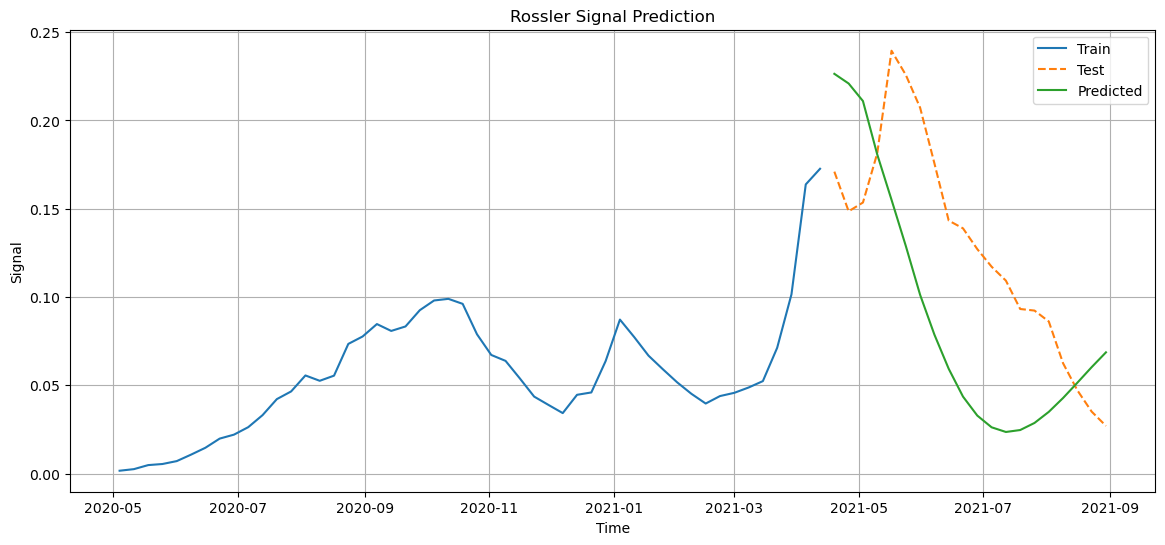

In [13]:
fig = plt.figure(figsize = (14,6))
plt.plot(t_1,raw_seq_1,label='Train')
plt.plot(t_window,raw_seq_window,'--',label='Test')
plt.plot(t_window,predicciones_adelante_1,label='Predicted')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Rossler Signal Prediction')
plt.legend()
plt.savefig('figures/rossler_signal_prediction_1.png')
plt.show()

In [14]:
# split into samples
predicciones_adelante_2_bw,valores_reales_2_bw = make_predictions(raw_seq_2_bw, look_back, n_features, raw_seq_window[::-1])

1/1 [==============================] - 0s 15ms/step


In [15]:
predicciones_adelante_2 = predicciones_adelante_2_bw[::-1]
valores_reales_2 = valores_reales_2_bw[::-1]

# Calculamos el error
diferencia_2 = np.abs(predicciones_adelante_2-raw_seq_window)

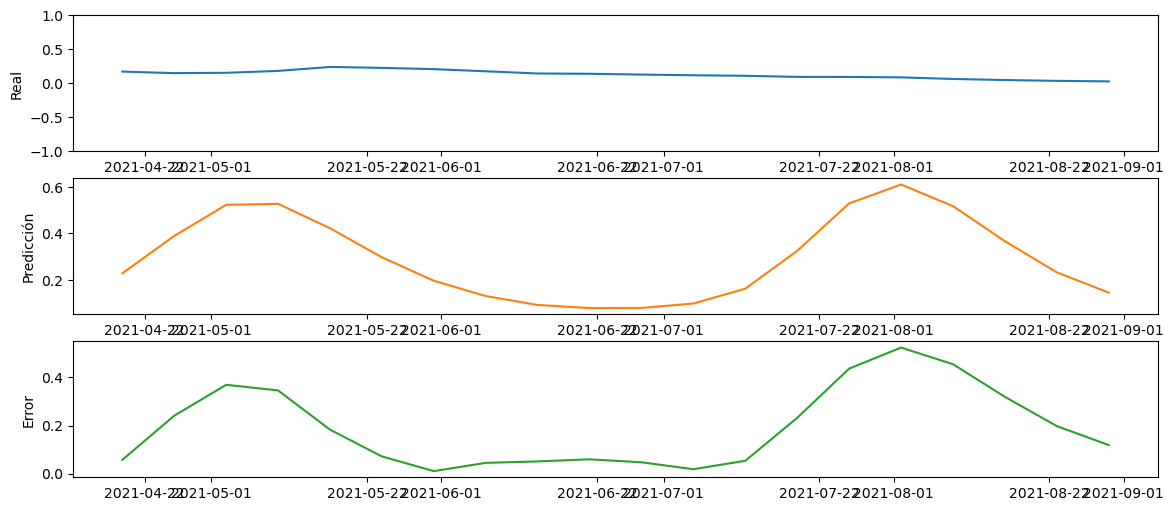

In [16]:
fig = plt.figure(figsize = (14,6))
plt.subplot(3,1,1)
plt.plot(t_window,raw_seq_window)
plt.ylabel('Real')
plt.ylim(-1,1)
plt.subplot(3,1,2)
plt.plot(t_window,predicciones_adelante_2,c='C1')
plt.ylabel('Predicción')
#plt.ylim(-1,1)
plt.subplot(3,1,3)
plt.plot(t_window,diferencia_2,c='C2')
plt.ylabel('Error')
#plt.ylim(0,5)
plt.show()

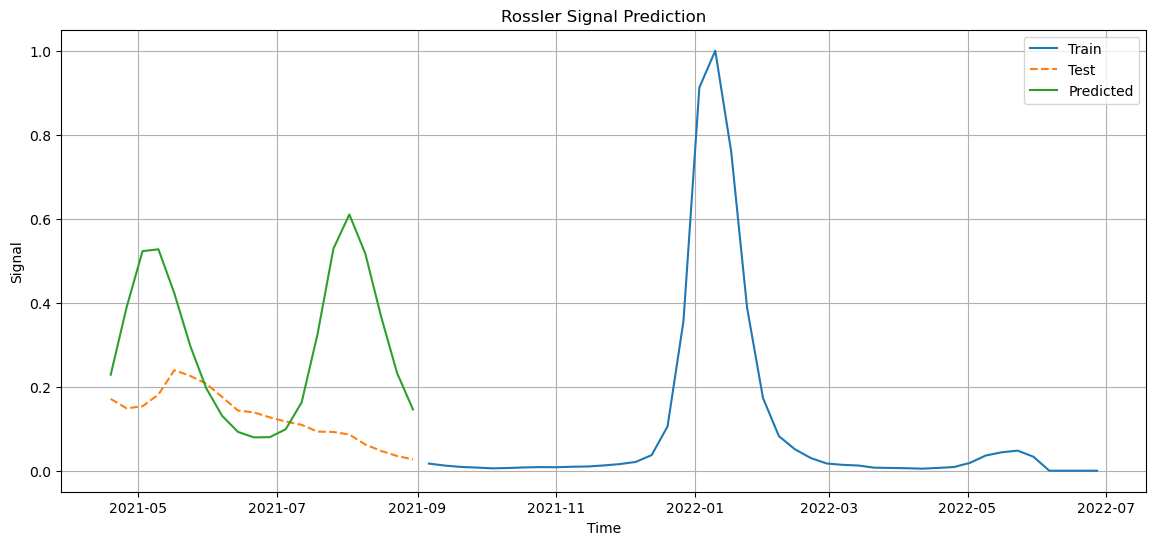

In [17]:
fig = plt.figure(figsize = (14,6))
plt.plot(t_2,raw_seq_2,label='Train')
plt.plot(t_window,raw_seq_window,'--',label='Test')
plt.plot(t_window,predicciones_adelante_2,label='Predicted')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Rossler Signal Prediction')
plt.legend()
plt.savefig('figures/rossler_signal_prediction_2.png')
plt.show()

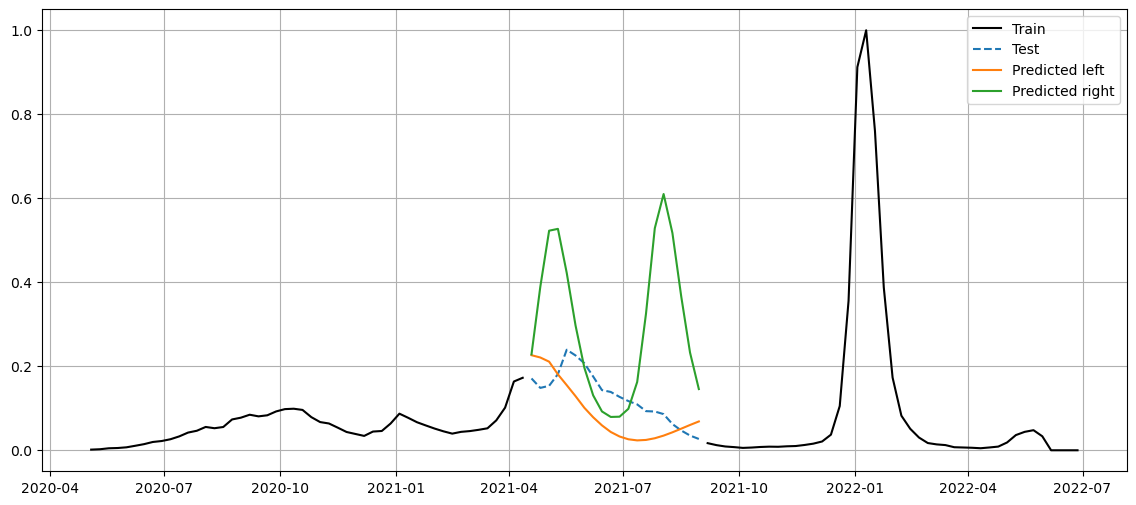

In [18]:
fig = plt.figure(figsize = (14,6))
plt.plot(t_1,raw_seq_1,'k',label='Train')
plt.plot(t_window,valores_reales_1,'--',label='Test')
plt.plot(t_window,predicciones_adelante_1,label='Predicted left')
plt.plot(t_2,raw_seq_2,'k')
plt.plot(t_window,predicciones_adelante_2,label='Predicted right')
plt.grid()
plt.legend()


In [19]:
prediction_mean = (predicciones_adelante_1 + predicciones_adelante_2)/2


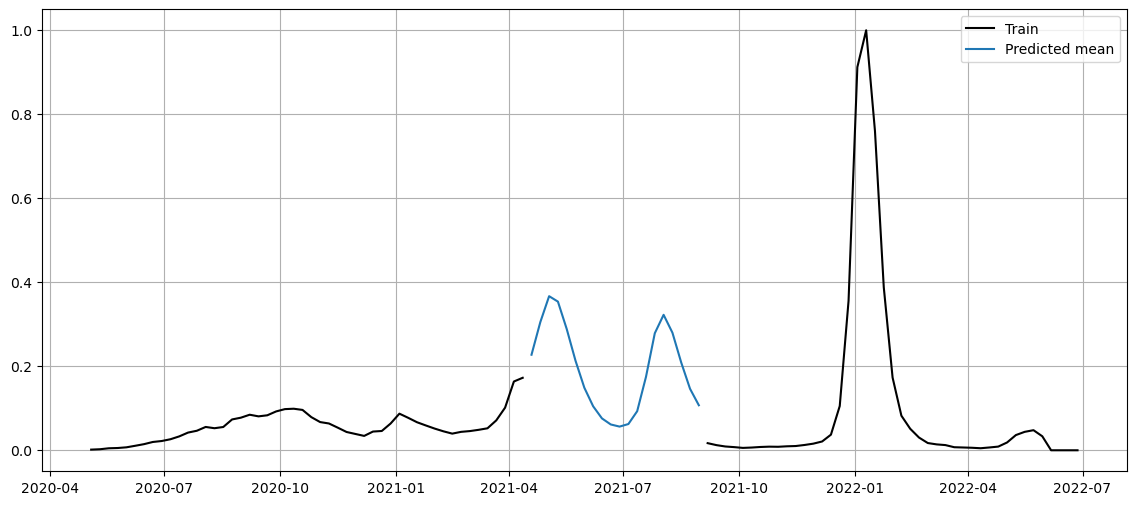

In [20]:
fig = plt.figure(figsize = (14,6))
plt.plot(t_1,raw_seq_1,'k',label='Train')
plt.plot(t_window,prediction_mean,label='Predicted mean')
plt.plot(t_2,raw_seq_2,'k')
plt.grid()
plt.legend()
